In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
from matplotlib import pyplot as plt
from tensorflow import keras
import pandas as pd
import itertools
from functools import partial
import pdb
import pickle
import base64
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *

from analysis.hit_rate_analysis import (
    seq_contains_12ca5_motif,
    seq_contains_mdm2_motif,
    find_mdm2_motif,
    find_12ca5_motif,
)
from utils.utils import seed_everything
from models.rnn import multi_channel_mse
from IPython.utils import io
from tqdm import tqdm

2023-06-20 16:41:05.481885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 16:41:05.639220: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-20 16:41:06.187151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-06-20 16:41:06.187211: W ten

In [2]:
other_protein = "MDM2"
protein_of_interest = "12ca5"

X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile =f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest, 
    other_protein=other_protein
)
seed_everything(0)


/home/yitongt/ml_phage/src/preprocessing/y_representation.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
2023-06-20 16:41:11.899818: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Shapely Analysis

In [ ]:
results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=128),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name="trained_models/final_models/mdm2_model.h5"
    if protein_of_interest == "12ca5"
    else "trained_models/final_models/12ca5_model.h5",
    normalize=True,
    batch_size=128,
    num_epochs=5,
)
mdm2_models = [result.trained_model for result in results]


In [ ]:
from analysis.shapley_additive_analysis import shapley_analysis, INVESTIGATION_TYPE
from tqdm import tqdm

all_targets = list(zip(X, peptides))


def investigate_individual_peptide(
    peptide_seq,
    model,
    show_plot=True,
    num_background_samples=200,
    num_perturbation_samples=2000,
):
    print(
        f"{peptide_seq} is in the dataset as {y_raw[[idx for idx, x in enumerate(peptides) if x == peptide_seq][0]]}"
    )
    attribution = shapley_analysis(
        model,
        X,
        [x for x in all_targets if x[1] == peptide_seq],  # Known binder
        investigation_type=INVESTIGATION_TYPE.BY_AMINO_ACID,
        num_background_samples=num_background_samples,
        num_perturbation_samples=num_perturbation_samples,
        aa_feature_dim=len(FEATURE_LIST),
        show_plot=show_plot,
    )
    return attribution


/home/yitongt/.conda/envs/novo_asms/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import random

def calculate_aggregated_shap_values(
    aligned_peptides,
    mdm2_models,
    finished_shap_values,
    left_boundary_increase=1,
    right_boundary_increase=1,
    run_model_ensemble=False,
):
    def define_range(
        match,
        array,
        blank,
    ):
        """
        We endevor to look at space before and after the match
        (to expand the analysis past just the motif)
        but this requires us gracefully handle when the motif is either
        at the beginning or end of the peptide.
        """
        left_of_motif_array = []
        for left_idx in range(-left_boundary_increase, 0):
            left_of_motif_array.append(
                blank if (match[0] + left_idx) < 0 else array[match[0] + left_idx]
            )

        right_of_motif_array = []
        for right_idx in range(0, right_boundary_increase):
            right_of_motif_array.append(
                blank
                if (match[1] + right_idx) >= len(array)
                else array[match[1] + right_idx]
            )
        return [
            *left_of_motif_array,
            *array[match[0] : match[1]],
            *right_of_motif_array,
        ]

    if not os.path.isfile(finished_shap_values):
        pd.DataFrame({"peptide": [], "collected_shap_values": []}).to_csv(
            finished_shap_values
        )
    finished_df = pd.read_csv(finished_shap_values, index_col=0)
    for idx, (peptide_of_interest, match) in tqdm(
        enumerate(aligned_peptides), total=len(aligned_peptides)
    ):
        collected_shap_values = []
        if peptide_of_interest in finished_df["peptide"].tolist():
            print("we are skipping! ", peptide_of_interest)
            continue
        if run_model_ensemble:
            for model in mdm2_models:
                with io.capture_output() as captured:
                    attribution = investigate_individual_peptide(
                        peptide_seq=peptide_of_interest,
                        model=model,
                        show_plot=False,
                        num_background_samples=100,
                        num_perturbation_samples=1000,
                    )
                    collected_shap_values.append(
                        (
                            define_range(match, attribution, blank=0),
                            define_range(match, peptide_of_interest, blank=" ")
                        )
                    )
        else:
            model = random.choice(mdm2_models)
            with io.capture_output() as captured:
                attribution = investigate_individual_peptide(
                    peptide_seq=peptide_of_interest,
                    model=model,
                    show_plot=False,
                    num_background_samples=100,
                    num_perturbation_samples=1000,
                )
                collected_shap_values.append(
                    (
                        define_range(match=match, array=attribution, blank=0),
                        define_range(match=match, array=peptide_of_interest, blank=" ")
                    )
                )
        serialized_data = pickle.dumps(collected_shap_values)
        encoded_data = base64.b64encode(serialized_data).decode()
        finished_df = finished_df.append(
            pd.Series(
                {
                    "peptide": peptide_of_interest,
                    "collected_shap_values": encoded_data,
                }
            ),
            ignore_index=True
        )
        finished_df.to_csv(finished_shap_values)
        gc.collect()

In [ ]:
import pandas as pd

mdm2_motif_peptides = [
    (peptide, find_mdm2_motif(peptide).span())
    for peptide in peptides
    if seq_contains_mdm2_motif(peptide)
]
ca5_motif_peptides = [
    (peptide, find_12ca5_motif(peptide).span())
    for peptide in peptides
    if seq_contains_12ca5_motif(peptide)
]
motif_peptides = (
    mdm2_motif_peptides if protein_of_interest == "MDM2" else ca5_motif_peptides
)
finished_shap_values = (
    "mdm2_shap_values.csv" if protein_of_interest == "MDM2" else "12ca5_shap_values.csv"
)

# This takes ~30 hours, so we are just going to pull from the saved results
# calculate_aggregated_shap_values(
#     left_boundary_increase=1 if protein_of_interest == "MDM2" else 4,
#     aligned_peptides=motif_peptides,
#     mdm2_models=mdm2_models,
#     finished_shap_values=finished_shap_values,
# )


## Time to plot results

In [ ]:

residue_labels=["*", "F", "*", "*", "Hydrophobe", "Hydrophobe", "*"] if protein_of_interest =='MDM2' else ["*", "*", "*", "*", "D", "Y", "A/S", "*"]
pickle_filename="mdm2_shap_value_comparison.pickle" if protein_of_interest =='MDM2' else "12ca5_shap_value_comparison.pickle"
title = f"Aggregated Shap Values over {protein_of_interest} Motif Containing Peptides"
aa_to_marker = {
    "C": ".",  # point marker
    "Q": ",",  # pixel marker
    "E": "o",  # circle marker
    "G": "v",  # triangle_down marker
    "H": "^",  # triangle_up marker
    "I": "<",  # triangle_left marker
    "L": ">",  # triangle_right marker
    "K": "1",  # tri_down marker
    "M": "2",  # tri_up marker
    "F": "3",  # tri_left marker
    "P": "4",  # tri_right marker
    "S": "s",  # square marker
    "T": "p",  # pentagon marker
    "W": "*",  # star marker
    "Y": "h",  # hexagon1 marker
    "V": "H",  # hexagon2 marker
    "D": "+",  # plus marker
    "A": "x",  # x marker
    "R": "D",  # diamond marker
    "N": "d",  # thin_diamond marker
}
cm = plt.get_cmap("inferno")


In [ ]:
finished_df = pd.read_csv(finished_shap_values, index_col=0)
decoded_shap_vals = []
for idx, encoded_shap_val in enumerate(finished_df['collected_shap_values']):
    try:
        decoded_shap_vals.append(pickle.loads(base64.b64decode(encoded_shap_val)))
    except:
        continue

# decoded_shap_vals
# finished_df['decoded_shap_values'] = finished_df['collected_shap_values'].apply(lambda x: pickle.loads(base64.b64decode(x)))
# # Only take the first model's output to see what that looks like...
# finished_df['decoded_shap_values'] = finished_df['decoded_shap_values'].apply(lambda x: x[9:])
# collected_shap_values = list(itertools.chain(*finished_df['decoded_shap_values'].tolist()))
collected_shap_values = list(itertools.chain(*decoded_shap_vals))

print(len(decoded_shap_vals))
print(len(collected_shap_values))

title =f"Aggregated Shap Values over {protein_of_interest} Motif Containing Peptides (across all 10 Models)"


1003
1003


In [ ]:
residue_num = len(residue_labels)
# Matrix is the list (residue idx) of dictionaries (amino acids) of list (shap_values)
matrix = []

for residue_idx in range(residue_num):
    aa_to_shap_value_lookup = {}
    for shap_values, peptide_str in collected_shap_values:
        aa = peptide_str[residue_idx]
        if aa == " ":
            continue

        shap_val_per_aa = aa_to_shap_value_lookup.get(aa, [])
        shap_val_per_aa.append(shap_values[residue_idx])
        aa_to_shap_value_lookup[aa] = shap_val_per_aa
    matrix.append(aa_to_shap_value_lookup)


with open(pickle_filename, "wb") as handle:
    pickle.dump(matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def get_text_positions(x_data, y_data, txt_width, txt_height):
    text_positions = list(zip(x_data, y_data))
    for index, (x, y) in enumerate(text_positions):
        collision_text_positions = [
            (idx, (x_other, y_other))
            for idx, (x_other, y_other) in enumerate(text_positions)
            if (
                (abs(x_other - x) < txt_width * 2)
                and (abs(y_other - y) < txt_height * 2)
                and idx != index
            )
        ]
        print("yitong")
        print("for ", index, x, y)
        print("we have these collisions ", collision_text_positions)
        for idx, i in collision_text_positions:
            text_positions[idx] = (i[0] + 2 * txt_width, i[1])
    return np.array(text_positions)


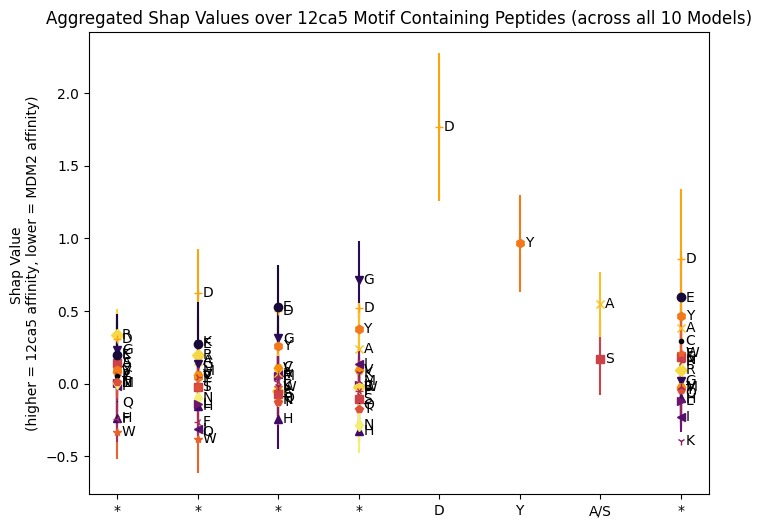

In [ ]:
residue_num = len(residue_labels)
NUM_COLORS = len(aa_to_marker)
color = [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]

aa_to_marker_and_color = {
    aa: (marker, color[idx]) for idx, (aa, marker) in enumerate(aa_to_marker.items())
}

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
finalized_shaps= []
for residue_idx, aa_to_shap_value_lookup in enumerate(matrix):
    mean_shaps = []
    aa_labels = []
    for aa, shap_vals in aa_to_shap_value_lookup.items():
        mean_shap = np.mean(shap_vals)
        mean_shaps.append(mean_shap)
        aa_labels.append(aa)
        std_dev_shap = np.std(shap_vals)
        marker, color = aa_to_marker_and_color[aa]
        ax.errorbar(
            x=residue_idx, y=mean_shap, yerr=std_dev_shap, fmt=marker, color=color
        )
        finalized_shaps.append({
            'aa': aa,
            'residue_idx': residue_idx,
            'mean_shap': mean_shap,
            'std_dev_shap': std_dev_shap,
        })

    for x, y, text in zip(
        [residue_idx + 0.06] * len(aa_to_shap_value_lookup), mean_shaps, aa_labels
    ):
        ax.text(
            x,
            y,
            text,
            horizontalalignment="left",
            verticalalignment="center",
        )

ax.set_xticks(np.arange(0, residue_num, step=1))
ax.set_xticklabels(residue_labels)
plt.title(title)
plt.ylabel(f"Shap Value \n(higher = {protein_of_interest} affinity, lower = {other_protein} affinity)")

finalized_shaps = pd.DataFrame(finalized_shaps)
finalized_shaps.to_csv(f'{protein_of_interest}_residue_shap_values.csv')


In [ ]:
from analysis.shapley_additive_analysis import shapley_analysis, INVESTIGATION_TYPE

investigation_target = all_targets[:1000]
with io.capture_output() as captured:
    explanation, features = shapley_analysis(
        mdm2_models[1],
        X,
        investigation_target, 
        investigation_type=INVESTIGATION_TYPE.BY_FEATURE,
        aa_feature_dim=len(FEATURE_LIST),
        feature_list=FEATURE_LIST,
    )

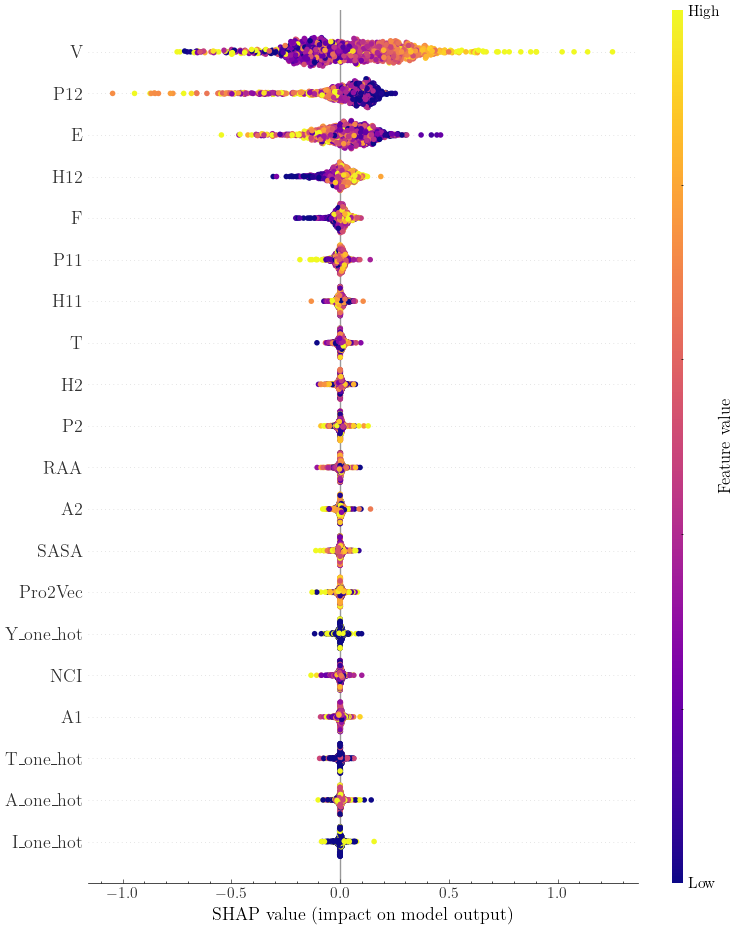

In [ ]:
import shap
shap.summary_plot(explanation, features, cmap="plasma", feature_names=FEATURE_LIST)